In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from google.colab import drive

# Attempt to unmount first
# try:
#     drive.flush_and_unmount()
# except ValueError:
#     print("Drive not mounted, proceeding to mount.")

drive.mount('/content/drive')

file_path = '/content/drive/MyDrive/IdVg_D1_21_2.txt'

def is_float_try(s):
    try:
        float(s)
        return True
    except:
        return False

# Read raw lines for inspection
with open(file_path, 'r', errors='ignore') as f:
    lines = f.readlines()

print("TOTAL RAW LINES:", len(lines))
print("\n----- First 10 raw lines (index:line) -----")
for i, line in enumerate(lines[:10]):
    print(f"{i:3d}: {line.rstrip()}")

# Load as strings so we can detect headers
df_raw = pd.read_csv(file_path, sep=r'\s+', header=None, dtype=str, engine='python', comment='#', skip_blank_lines=False)
print("\nRaw dataframe shape (as strings):", df_raw.shape)

# Detect header-like rows
def row_has_alpha_or_nonnum(row):
    for cell in row:
        if pd.isna(cell):
            continue
        s = str(cell).strip()
        if re.search(r'[A-Za-z]', s):
            return True
        if not is_float_try(s):
            # treat common non-numeric tokens as header-like
            return True
    return False

header_rows_mask = df_raw.apply(row_has_alpha_or_nonnum, axis=1)
header_row_indices = df_raw.index[header_rows_mask].tolist()
print("\nDetected header-like row indices (contain letters / non-numeric tokens):", header_row_indices)

# Show row counts before/after dropping
print("\nRows before dropping header-like rows:", df_raw.shape[0])
if header_row_indices:
    df_no_headers = df_raw.drop(index=header_row_indices).reset_index(drop=True)
else:
    df_no_headers = df_raw.copy()
print("Rows after dropping header-like rows:", df_no_headers.shape[0])

# Assign/infer column names from first header-like row if present
if header_row_indices:
    first_header = df_raw.loc[header_row_indices[0]].fillna('').astype(str).str.strip().tolist()
    col_names = [n if n != '' else f'col{j}' for j,n in enumerate(first_header)]
else:
    col_names = [f'col{j}' for j in range(df_no_headers.shape[1])]

# Convert to numeric where possible
df_clean = df_no_headers.applymap(lambda x: str(x).strip() if pd.notna(x) else x).replace({'': pd.NA})
df_numeric = df_clean.apply(lambda col: pd.to_numeric(col, errors='coerce'))

# Name columns sensibly (truncate/pad)
ncols = df_numeric.shape[1]
if len(col_names) >= ncols:
    df_numeric.columns = col_names[:ncols]
else:
    df_numeric.columns = col_names + [f'col{j}' for j in range(len(col_names), ncols)]

print("\nFinal numeric dataframe shape:", df_numeric.shape)
print("Column names:", list(df_numeric.columns))
print("\nNull counts per column:")
print(df_numeric.isna().sum())

# Safe sampling
n_rows = df_numeric.shape[0]
if n_rows > 0:
    sample_n = min(5, n_rows)
    print(f"\nShowing a random sample of {sample_n} rows:")
    print(df_numeric.sample(sample_n))
else:
    print("\nWARNING: No numeric rows after cleaning. Here are the first 20 rows of the non-header (string) dataframe for inspection:")
    print(df_no_headers.head(20))

# Safe plotting: only if we have rows and at least two columns
if n_rows > 0 and df_numeric.shape[1] >= 2:
    # Heuristic: name first column 'Bias' if it doesn't have a bias-like name
    first_col = df_numeric.columns[0]
    if 'bias' not in str(first_col).lower():
        df_numeric = df_numeric.rename(columns={first_col: 'Bias'})
    if 'Bias' in df_numeric.columns:
        plt.figure(figsize=(10,6))
        cols_to_plot = [c for c in df_numeric.columns if c != 'Bias']
        for col in cols_to_plot[:20]:
            plt.plot(df_numeric['Bias'], df_numeric[col], marker='.', linestyle='-',
                     label=str(col))
        plt.xlabel('Bias')
        plt.ylabel('Measurement')
        plt.title('Bias vs Measurements (first 20 columns)')
        plt.legend(fontsize='small', ncol=2)
        plt.grid(True)
        plt.show()
    else:
        print("No 'Bias' column found; skipping plot.")
else:
    print("Not enough numeric data to plot (need at least 1 row and 2 columns).")

Mounted at /content/drive
TOTAL RAW LINES: 112

----- First 10 raw lines (index:line) -----
  0:    0.0000000e+00   0.0000000e+00   1.0000000e+00   2.0000000e+00   3.0000000e+00   4.0000000e+00   5.0000000e+00   6.0000000e+00   7.0000000e+00   8.0000000e+00   9.0000000e+00   1.0000000e+01   0.0000000e+00   0.0000000e+00   1.0000000e+00   2.0000000e+00   3.0000000e+00   4.0000000e+00   5.0000000e+00   6.0000000e+00   7.0000000e+00   8.0000000e+00   9.0000000e+00   1.0000000e+01
  1:   -1.0000000e+01   4.5770100e-08   5.5600200e-08   9.0748900e-08   1.4393900e-07   1.5994200e-07   1.3265600e-07   1.7452700e-07   1.8190100e-07   1.6668100e-07   2.4595400e-07   1.7733800e-07   0.0000000e+00  -1.3090300e-07  -1.3934500e-07  -2.0025700e-07  -2.5522700e-07  -2.8367700e-07  -2.4835400e-07  -2.7620000e-07  -2.8275200e-07  -2.9903000e-07  -3.3768300e-07  -2.5006100e-07
  2:   -9.9000000e+00   4.9626300e-08   6.4803200e-08   9.4789300e-08   1.3521900e-07   1.6553300e-07   1.3174900e-07   1.614190

/tmp/ipython-input-1402360099.py:70: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_clean = df_no_headers.applymap(lambda x: str(x).strip() if pd.notna(x) else x).replace({'': pd.NA})


[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.] [-10.   -9.9  -9.8  -9.7  -9.6  -9.5  -9.4  -9.3  -9.2  -9.1  -9.   -8.9
  -8.8  -8.7  -8.6  -8.5  -8.4  -8.3  -8.2  -8.1  -8.   -7.9  -7.8  -7.7
  -7.6  -7.5  -7.4  -7.3  -7.2  -7.1  -7.   -6.9  -6.8  -6.7  -6.6  -6.5
  -6.4  -6.3  -6.2  -6.1  -6.   -5.9  -5.8  -5.7  -5.6  -5.5  -5.4  -5.3
  -5.2  -5.1  -5.   -4.9  -4.8  -4.7  -4.6  -4.5  -4.4  -4.3  -4.2  -4.1
  -4.   -3.9  -3.8  -3.7  -3.6  -3.5  -3.4  -3.3  -3.2  -3.1  -3.   -2.9
  -2.8  -2.7  -2.6  -2.5  -2.4  -2.3  -2.2  -2.1  -2.   -1.9  -1.8  -1.7
  -1.6  -1.5  -1.4  -1.3  -1.2  -1.1  -1.   -0.9  -0.8  -0.7  -0.6  -0.5
  -0.4  -0.3  -0.2  -0.1   0.    0.1   0.2   0.3   0.4   0.5   0.6   0.7
   0.8   0.9   1. ] [[ 4.57701e-08  5.56002e-08  9.07489e-08 ...  1.66681e-07  2.45954e-07
   1.77338e-07]
 [ 4.96263e-08  6.48032e-08  9.47893e-08 ...  2.08250e-07  2.40436e-07
   1.58318e-07]
 [ 5.91935e-08  6.72784e-08  9.30706e-08 ...  1.99375e-07  2.31130e-07
   1.50414e-07]
 ...
 [-3.56441e

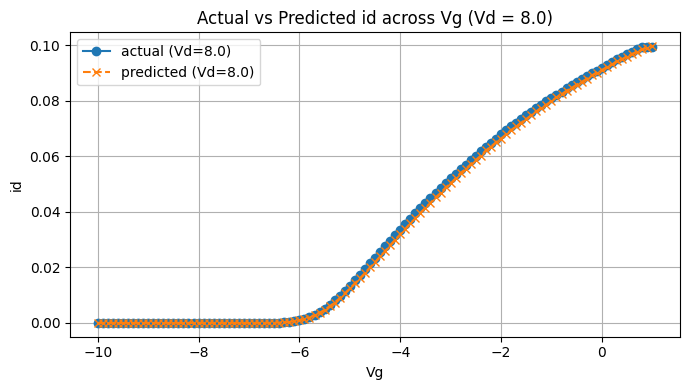

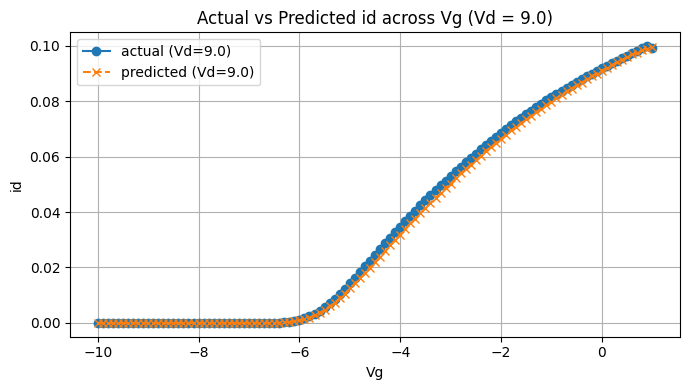

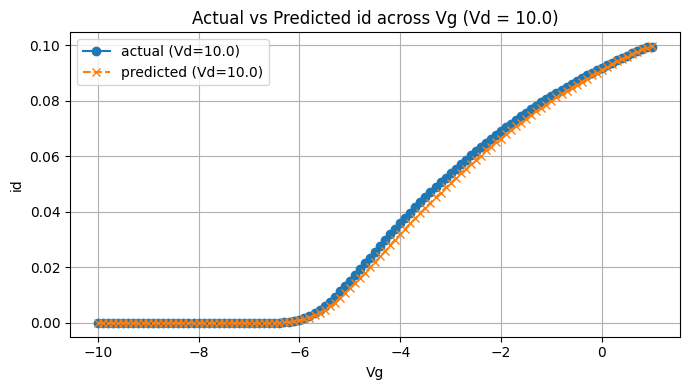

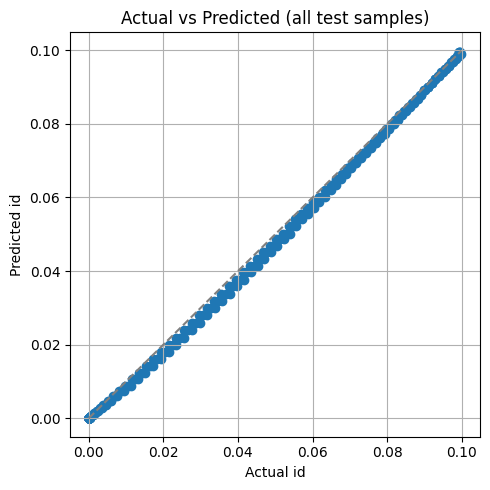


Sample of predictions:
   Vg  Vd    id_actual      id_pred
-10.0 8.0 1.666810e-07 1.669768e-07
 -9.9 8.0 2.082500e-07 1.658067e-07
 -9.8 8.0 1.993750e-07 1.628862e-07
 -9.7 8.0 1.907090e-07 1.598990e-07
 -9.6 8.0 1.815180e-07 1.520872e-07
 -9.5 8.0 1.859850e-07 1.459557e-07
 -9.4 8.0 1.742490e-07 1.357841e-07
 -9.3 8.0 1.702080e-07 1.054215e-07
 -9.2 8.0 1.664170e-07 9.817141e-08
 -9.1 8.0 1.719760e-07 9.631261e-08
 -9.0 8.0 1.683950e-07 9.593834e-08
 -8.9 8.0 1.659010e-07 9.566295e-08
 -8.8 8.0 1.592350e-07 9.541801e-08
 -8.7 8.0 1.516410e-07 9.517821e-08
 -8.6 8.0 1.408710e-07 9.467963e-08
 -8.5 8.0 1.389570e-07 9.457927e-08
 -8.4 8.0 1.363900e-07 9.427730e-08
 -8.3 8.0 1.364200e-07 9.427730e-08
 -8.2 8.0 1.265210e-07 9.427730e-08
 -8.1 8.0 1.273860e-07 9.427730e-08


In [ ]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import pickle
import os

# Use df_numeric created earlier in your notebook
# Defensive cleanup: drop all-empty rows/cols and reset index
df_num = df_raw.dropna(how='all').dropna(axis=1, how='all').reset_index(drop=True)
# df_num.head()

# Ensure we have at least 2 rows (header + at least one Vg) and >=8 columns as requested
if df_num.shape[0] < 2:
    raise RuntimeError("Not enough rows after cleaning. Need at least header row + one data row.")
if df_num.shape[1] < 8:
    raise RuntimeError(f"Need at least 8 columns; found {df_num.shape[1]}. Check your parsed dataframe.")

# Keep only the first 8 columns (index 0..9)
df8 = df_num.iloc[:, :12].astype(float).copy()

# Convert to numpy array for indexing convenience
arr = df8.values  # shape (n_rows, 8)

# According to your format:
# - arr[0, :] is the Vd header row (first column is meaningless zero)
# - arr[1:, 0] are Vg values
# - arr[1:, 1:] is the id matrix: rows -> Vg, cols -> Vd
Vd_vals = arr[0, 1:]          # length 7 (Vd values for columns 1..7)
Vg_vals = arr[1:, 0]         # length n_vg
id_matrix = arr[1:, 1:]      # shape (n_vg, n_vd=7)

print(Vd_vals, Vg_vals, id_matrix)

n_vg, n_vd = id_matrix.shape
print(f"Parsed: n_vg (rows) = {n_vg}, n_vd (cols) = {n_vd}")
print("Vd values (parsed from header):", Vd_vals)

# Check for NaNs and warn
if np.isnan(Vd_vals).any():
    print("Warning: some Vd header values are NaN. Those columns will be skipped automatically.")

# Define train/test Vd columns as you asked:
# Train: columns 2-6 (1-based) -> indices 0..4 in id_matrix
# Test: columns 7-8 (1-based) -> indices 5..6 in id_matrix
train_col_indices = list(range(0, min(8, n_vd)))
test_col_indices  = list(range(8, min(11, n_vd)))

if len(test_col_indices) == 0:
    raise RuntimeError("No test Vd columns found in positions 7-8 (ids columns). Please check data or adjust indices.")

print("Train id columns (indices relative to id_matrix):", train_col_indices)
print("Test  id columns (indices relative to id_matrix):", test_col_indices)

# Build (Vg, Vd) -> id dataset and split by Vd column membership
X_train = []
y_train = []
X_test  = []
y_test  = []

for i in range(n_vg):
    vg = Vg_vals[i]
    for j in range(n_vd):
        vd = Vd_vals[j]
        val = id_matrix[i, j]
        if np.isnan(val) or np.isnan(vg) or np.isnan(vd):
            continue
        if j in train_col_indices:
            X_train.append([vg, vd])
            y_train.append(val)
        elif j in test_col_indices:
            X_test.append([vg, vd])
            y_test.append(val)
        # else: ignore any columns outside train/test selection

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test  = np.array(X_test)
y_test  = np.array(y_test)

print(f"Training samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")

if X_train.shape[0] == 0 or X_test.shape[0] == 0:
    raise RuntimeError("Empty train or test set after splitting. Check that the id matrix had values in the requested columns.")

# Optional: add simple engineered features (uncomment if desired)
# from sklearn.preprocessing import PolynomialFeatures
# pf = PolynomialFeatures(degree=2, include_bias=False)
# X_train = pf.fit_transform(X_train)
# X_test  = pf.transform(X_test)

# Train a RandomForest regressor (you can swap to any regressor)
model = RandomForestRegressor(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f"\nTest R^2: {r2:.6f}, Test MSE: {mse:.6e}")

# Build a results DataFrame and save
results_df = pd.DataFrame({
    "Vg": X_test[:, 0],
    "Vd": X_test[:, 1],
    "id_actual": y_test,
    "id_pred": y_pred
})
# sort rows for nicer plotting
results_df = results_df.sort_values(["Vd", "Vg"]).reset_index(drop=True)

out_dir = os.path.dirname(file_path) or "."
pred_file = os.path.join(out_dir, "predictions.csv")
results_df.to_csv(pred_file, index=False)
print(f"Saved predictions to: {pred_file}")

# Save model
model_file = os.path.join(out_dir, "rf_id_model.pkl")
with open(model_file, "wb") as f:
    pickle.dump(model, f)
print(f"Saved trained model to: {model_file}")

# ------------------ Plots ------------------
# 1) For each test Vd, plot Vg vs actual and predicted
unique_test_vd = sorted(results_df["Vd"].unique())
for vd in unique_test_vd:
    sub = results_df[results_df["Vd"] == vd].sort_values("Vg")
    plt.figure(figsize=(7,4))
    plt.plot(sub["Vg"], sub["id_actual"], marker='o', linestyle='-', label=f"actual (Vd={vd})")
    plt.plot(sub["Vg"], sub["id_pred"], marker='x', linestyle='--', label=f"predicted (Vd={vd})")
    plt.xlabel("Vg")
    plt.ylabel("id")
    plt.title(f"Actual vs Predicted id across Vg (Vd = {vd})")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 2) Overall actual vs predicted scatter (with y=x ref)
plt.figure(figsize=(5,5))
plt.scatter(results_df["id_actual"], results_df["id_pred"])
mn = min(results_df["id_actual"].min(), results_df["id_pred"].min())
mx = max(results_df["id_actual"].max(), results_df["id_pred"].max())
plt.plot([mn, mx], [mn, mx], linestyle='--', color='gray')
plt.xlabel("Actual id")
plt.ylabel("Predicted id")
plt.title("Actual vs Predicted (all test samples)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Print a small table of results
print("\nSample of predictions:")
print(results_df.head(20).to_string(index=False))


In [ ]:
# -----------------------------------------------------------
#  SAVE id MATRIX IN THE FORMAT YOU ASKED
#  First row  : 0 Vd1 Vd2 Vd3 ...
#  Next rows  : Vg   id(Vg,Vd1) id(Vg,Vd2) ...
# -----------------------------------------------------------

# Build a new id matrix from results_df
unique_vg = sorted(results_df["Vg"].unique())
unique_vd = sorted(results_df["Vd"].unique())

# Prepare a 2D matrix of current values
id_mat = np.zeros((len(unique_vg), len(unique_vd)))

for i, vg in enumerate(unique_vg):
    for j, vd in enumerate(unique_vd):
        row = results_df[(results_df["Vg"] == vg) & (results_df["Vd"] == vd)]
        if not row.empty:
            id_mat[i, j] = row["id_actual"].values[0]

# Save in plain-text format
out_file = os.path.join(out_dir, "IdVg_predicted_values.txt")

with open(out_file, "w") as f:
    # First row: "0 Vd1 Vd2 Vd3 ..."
    f.write("0 " + " ".join(str(vd) for vd in unique_vd) + "\n")

    # Next rows: "Vg id1 id2 id3 ..."
    for i, vg in enumerate(unique_vg):
        row_values = " ".join(str(x) for x in id_mat[i])
        f.write(f"{vg} {row_values}\n")

print("Saved formatted id matrix to:", out_file)


Saved formatted id matrix to: /content/drive/MyDrive/IdVg_predicted_values.txt


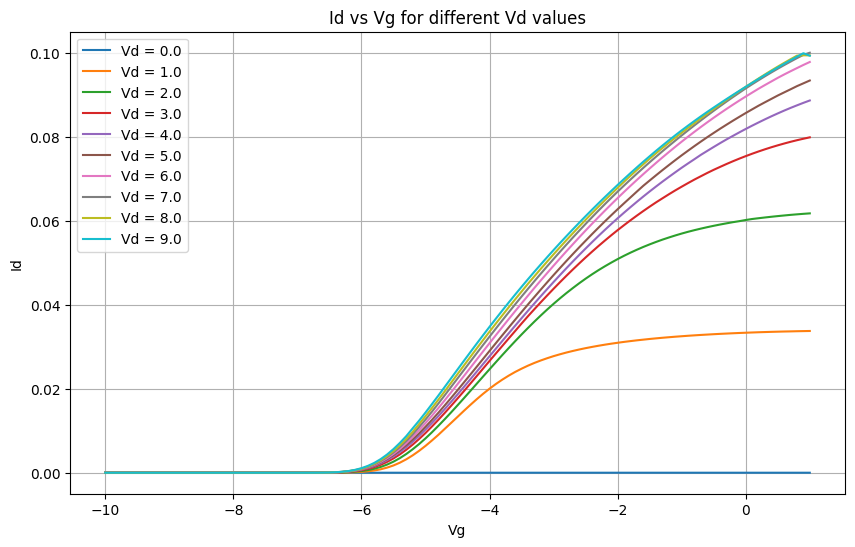

In [ ]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import pickle
import os

plt.figure(figsize=(10,6))

for j, vd in enumerate(Vd_vals):
    if np.isnan(vd):
        continue
    plt.plot(Vg_vals, id_matrix[:, j], label=f"Vd = {vd}")

plt.xlabel("Vg")
plt.ylabel("Id")
plt.title("Id vs Vg for different Vd values")
plt.legend()
plt.grid(True)
plt.show()

